## 2. mAP analysis

In this notebook we are analyzing the mAP scores generate from the previous step shown [here](./1.run-map.ipynb). In this note book, we are investigating that mAP scores generated to see if we can identify specific compounds that show evidence of reversing cardiac fibroblast. 

In [1]:
import pathlib
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Setting helper functions 

In [2]:
def rename_map_columns(map_df, prefix):
    """Renames mAP score columns with a specified prefix (negative or positive).

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    prefix : str
        Prefix to add to the column names (e.g., 'negative' or 'positive').

    Returns
    -------
    pandas.DataFrame
        DataFrame with renamed columns.
    """
    return map_df.rename(
        columns={
            "mean_average_precision": f"{prefix}_mean_average_precision",
            "corrected_p_value": f"{prefix}_corrected_p_value",
        }
    )


def calculate_delta_map(map_df):
    """Calculates delta mAP as the difference between negative and positive mean average precision.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores with 'negative_mean_average_precision' and
        'positive_mean_average_precision' columns.

    Returns
    -------
    pandas.DataFrame
        DataFrame with an additional 'delta_mAP' column.
    """
    map_df["delta_mAP"] = (
        map_df["negative_mean_average_precision"]
        - map_df["positive_mean_average_precision"]
    )
    return map_df


def add_pathway_info(map_df, pathway_df):
    """Merges pathway information into the dataframe and removes the 'UCD ID' column.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    pathway_df : pandas.DataFrame
        DataFrame containing pathway information with 'UCD ID' and 'Pathway' columns.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged pathway information.
    """
    return map_df.merge(
        pathway_df, left_on="Metadata_treatment", right_on="UCD ID", how="inner"
    ).drop(columns="UCD ID")


def filter_ref_control(map_df, ref_type, control_type, value_column):
    """Filters dataframe based on reference and control type, selecting relevant columns.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    ref_type : str
        Type of reference control (e.g., 'positive' or 'negative').
    control_type : str
        Type of control (e.g., 'positive' or 'negative').
    value_column : str
        Name of the column containing the mAP scores to be selected.

    Returns
    -------
    pandas.DataFrame
        Filtered DataFrame containing only the relevant columns.
    """
    return map_df.loc[
        (map_df["Metadata_reference_control_type"] == ref_type)
        & (map_df["Metadata_control_type"] == control_type),
        ["Metadata_plate_barcode", "Metadata_control_type", value_column],
    ]

Setting up input and output paths

In [3]:
results_dir = pathlib.Path("./results").resolve(strict=True)
map_scores_dir = (results_dir / "map_scores").resolve(strict=True)


# Setting original mAP scores paths for treatments
nc_dmso_map_path = (
    map_scores_dir / "batch_1_original_negative_control_failing_DMSO_trt_mAP_scores.csv"
).resolve(strict=True)
pc_dmso_map_path = (
    map_scores_dir / "batch_1_original_positive_control_healthy_DMSO_trt_mAP_scores.csv"
).resolve(strict=True)

# Setting shuffled mAP scores paths for treatments
shuffled_nc_dmso_map_path = (
    map_scores_dir / "batch_1_shuffled_negative_control_failing_DMSO_trt_mAP_scores.csv"
).resolve(strict=True)
shuffled_pc_dmso_map_path = (
    map_scores_dir / "batch_1_shuffled_positive_control_healthy_DMSO_trt_mAP_scores.csv"
).resolve(strict=True)

# Setting original dmso mAP scores paths
positive_mAP_scores_path = (
    map_scores_dir / "batch_1_original_positive_ref_dmso_mAP_scores.csv"
).resolve(strict=True)
negref_mAP_scores_path = (
    map_scores_dir / "batch_1_original_negative_ref_dmso_mAP_scores.csv"
).resolve(strict=True)

# Setting shuffled dmso mAP scores paths
shuffled_posref_mAP_scores_path = (
    map_scores_dir / "batch_1_original_positive_ref_dmso_mAP_scores.csv"
).resolve(strict=True)
shuffled_negref_mAP_scores_path = (
    map_scores_dir / "batch_1_original_negative_ref_dmso_mAP_scores.csv"
)

# make directory for figures
map_analysis_results_dir = (results_dir / "map_analysis").resolve()
map_analysis_results_dir.mkdir(exist_ok=True)

fig_dir_path = (map_analysis_results_dir / "figures").resolve()
fig_dir_path.mkdir(exist_ok=True)

# pathway informaiton
pathway_info = pathlib.Path(
    "../data/metadata/original_platemaps/pathways_platemap.csv"
).resolve(strict=True)

## Loading in DMSO mAP scores
Next, we separate the mAP scores and label them as "positive_ref_mAP" or "negative_ref_mAP", depending on the reference used in the calculation. These labels indicate whether the reference was a positive or negative control. The positive control represents healthy CF cells treated with DMSO, while the negative control represents failing CF cells treated with DMSO.

The goal is to assess the consistency and quality of our controls. Specifically, we expect negative controls (when using a negative control as the reference) to yield low mAP scores, indicating that negative controls compared against each other exhibit similar phenotypic profiles. Conversely, when using a negative control target with a positive control reference, we expect high mAP scores, as these controls correspond to distinctly different phenotypic profiles. Similarly, when using the positive control as the target, we expect the same trends but with the mAP scores reversed based on the reference.

Since both negative and positive controls are assigned per plate, each plate contributes two mAP scores for each control type:
- "positive_ref_mAP": The mAP score when using the positive control as the reference.
- "negative_ref_mAP": The mAP score when using the negative control as the reference.


Loading mAP scores generated from both original and shuffled data

In [4]:
# Load the original mAP scores
negref_mAP_df = pd.read_csv(negref_mAP_scores_path)
posref_mAP_df = pd.read_csv(positive_mAP_scores_path)

# Load the shuffled mAP scores
shuffled_negref_map_df = pd.read_csv(shuffled_negref_mAP_scores_path)
shuffled_posref_map_df = pd.read_csv(shuffled_posref_mAP_scores_path)

# Rename the 'mean_average_precision' column to 'positive_ref_mAP' and 'negative_ref_mAP'
negref_mAP_df = negref_mAP_df.rename(
    columns={"mean_average_precision": "negative_ref_mAP"}
)
posref_mAP_df = posref_mAP_df.rename(
    columns={"mean_average_precision": "positive_ref_mAP"}
)
shuffled_negref_map_df = shuffled_negref_map_df.rename(
    columns={"mean_average_precision": "negative_ref_mAP"}
)
shuffled_posref_map_df = shuffled_posref_map_df.rename(
    columns={"mean_average_precision": "positive_ref_mAP"}
)

After the plates are loaded when then filter and organize the mAP scores into a table where we want to separated the scores generated from difference references. Where if the target was a positive control and the reference 

In [5]:
# Apply function to original data
posref_postrgt_df = filter_ref_control(
    posref_mAP_df, "positive", "positive", "positive_ref_mAP"
)
posref_negtrgt_df = filter_ref_control(
    posref_mAP_df, "positive", "negative", "positive_ref_mAP"
)
negref_postrgt_df = filter_ref_control(
    negref_mAP_df, "negative", "positive", "negative_ref_mAP"
)
negref_negtrgt_df = filter_ref_control(
    negref_mAP_df, "negative", "negative", "negative_ref_mAP"
)

# Apply function to shuffled data
shuffled_posref_postrgt_df = filter_ref_control(
    shuffled_posref_map_df, "positive", "positive", "positive_ref_mAP"
)
shuffled_posref_negtrgt_df = filter_ref_control(
    shuffled_posref_map_df, "positive", "negative", "positive_ref_mAP"
)
shuffled_negref_postrgt_df = filter_ref_control(
    shuffled_negref_map_df, "negative", "positive", "negative_ref_mAP"
)
shuffled_negref_negtrgt_df = filter_ref_control(
    shuffled_negref_map_df, "negative", "negative", "negative_ref_mAP"
)


Next, we merge the dataframes to create a single dataframe that defines the X and Y values for the plots. The `negative_mean_precision` column represents mAP scores using the negative control as a reference, while `positive_mean_precision` represents the Y values, where mAP scores were calculated using positive controls as references. Additionally, we compute the delta mAP (`d_mAP`), which is the difference between the two:  `d_mAP = negative_mean_precision - positive_mean_precision}`

In [6]:
# Merge the data frames

# Merge mAP scores where the target was the positive control and the references are both positive and negative controls
pos_trg_mAP_scores_df = posref_postrgt_df.merge(
    negref_postrgt_df,
    on=["Metadata_plate_barcode", "Metadata_control_type"],
    how="inner",
)

# Merge mAP scores where the target was the negative control and the references are both positive and negative controls
neg_trg_mAP_scores = posref_negtrgt_df.merge(
    negref_negtrgt_df,
    on=["Metadata_plate_barcode", "Metadata_control_type"],
    how="inner",
)

# Merge shuffled mAP scores where the target was the positive control and the references are both positive and negative controls
shuffled_pos_trg_mAP_scores_df = shuffled_posref_postrgt_df.merge(
    shuffled_negref_postrgt_df,
    on=["Metadata_plate_barcode", "Metadata_control_type"],
    how="inner",
)

# Merge shuffled mAP scores where the target was the negative control and the references are both positive and negative controls
shuffled_neg_trg_mAP_scores_df = shuffled_posref_negtrgt_df.merge(
    shuffled_negref_negtrgt_df,
    on=["Metadata_plate_barcode", "Metadata_control_type"],
    how="inner",
)

# Concatenate the original mAP score data frames
original_dmso_map_df = pd.concat([pos_trg_mAP_scores_df, neg_trg_mAP_scores])
original_dmso_map_df["shuffled"] = (
    False  # Add a column to indicate these are not shuffled
)

# Concatenate the shuffled mAP score data frames
shuffled_dmso_map_df = pd.concat(
    [shuffled_pos_trg_mAP_scores_df, shuffled_neg_trg_mAP_scores_df]
)
shuffled_dmso_map_df["shuffled"] = True  # Add a column to indicate these are shuffled

# Concatenate the original and shuffled mAP score data frames into a main mAP score data frame for DMSO
dmso_map_df = pd.concat([original_dmso_map_df, shuffled_dmso_map_df]).rename(
    columns={"Metadata_control_type": "Metadata_target_control_type"}
)

# Setting column names to keep consistency with the rest of the analysis
cols = [
    "Metadata_treatment",
    "Pathway",
    "negative_mean_average_precision",
    "positive_mean_average_precision",
    "delta_mAP",
    "shuffled",
]

# adding a "Pathway" column to the dmso map scores and setting it as "DMSO"
dmso_map_df["Pathway"] = "DMSO"

# now update the DMSO label in the "Pathway" column in respect to their Metadata_target_control_type
# if the Metadata_target_control_type is "positive" then the Metadata_treatment is "DMSO-positive"
# if the Metadata_target_control_type is "negative" then the Metadata_treatment is "DMSO-negative"
dmso_map_df["Pathway"] = (
    dmso_map_df["Pathway"] + "-" + dmso_map_df["Metadata_target_control_type"]
)

# next to to calculate the delta_mAP
dmso_map_df["delta_mAP"] = (
    dmso_map_df["negative_ref_mAP"] - dmso_map_df["positive_ref_mAP"]
)

# next to rename the columns to keep consistency with the rest of the analysis
dmso_map_df = dmso_map_df.rename(
    columns={
        "Metadata_target_control_type": "Metadata_treatment",
        "negative_ref_mAP": "negative_mean_average_precision",
        "positive_ref_mAP": "positive_mean_average_precision",
    }
)
dmso_map_df = dmso_map_df[cols]
dmso_map_df

,Metadata_treatment,Pathway,negative_mean_average_precision,positive_mean_average_precision,delta_mAP,shuffled
0,positive,DMSO-positive,0.964104,0.820277,0.143827,False
1,positive,DMSO-positive,0.962343,0.802695,0.159648,False
2,positive,DMSO-positive,0.962690,0.809982,0.152708,False
3,positive,DMSO-positive,0.963192,0.814986,0.148206,False
0,negative,DMSO-negative,0.806241,0.973202,-0.166961,False
1,negative,DMSO-negative,0.786341,0.963402,-0.177061,False
2,negative,DMSO-negative,0.779157,0.961971,-0.182813,False
3,negative,DMSO-negative,0.804058,0.956554,-0.152496,False
0,positive,DMSO-positive,0.964104,0.820277,0.143827,True
1,positive,DMSO-positive,0.962343,0.802695,0.159648,True


Here we are calculating the delta mAP to all wells treated with a specific treatment. 

In [7]:
# columns that we are interested in
interested_cols = ["Metadata_treatment", "mean_average_precision", "corrected_p_value"]

# loading in the pathway information for each treatment
pathway_df = pd.read_csv(pathway_info)[["UCD ID", "Pathway"]]

# treatment mAP scores generated from original data
nc_map_df = pd.read_csv(nc_dmso_map_path)[interested_cols]
pc_map_df = pd.read_csv(pc_dmso_map_path)[interested_cols]

# treatment mAP scores generated from shuffled data
shuffled_nc_map_df = pd.read_csv(shuffled_nc_dmso_map_path)[interested_cols]
shuffled_pc_map_df = pd.read_csv(shuffled_pc_dmso_map_path)[interested_cols]

# rename columns for mAP scores generated from both original and shuffled
nc_map_df = rename_map_columns(nc_map_df, "negative")
pc_map_df = rename_map_columns(pc_map_df, "positive")
shuffled_nc_map_df = rename_map_columns(shuffled_nc_map_df, "negative")
shuffled_pc_map_df = rename_map_columns(shuffled_pc_map_df, "positive")

# merge both together
all_shuffled_trt_map_df = shuffled_nc_map_df.merge(
    shuffled_pc_map_df, on="Metadata_treatment", how="inner"
)
all_trt_map_df = nc_map_df.merge(pc_map_df, on="Metadata_treatment", how="inner")

# checking if none of the data has been dropped after
all_merged_df_rows = all_trt_map_df.shape[0]
assert (
    all_merged_df_rows == nc_map_df.shape[0]
    and all_merged_df_rows == pc_map_df.shape[0]
), "Row entries are not the same, missing some compounds after merge"
assert (
    all_merged_df_rows == shuffled_nc_map_df.shape[0]
    and all_merged_df_rows == shuffled_pc_map_df.shape[0]
), "Row entries are not the same, missing some compounds after merge"

# Apply the function to both original and shuffled data to calculate delta mAP
all_trt_map_df = calculate_delta_map(all_trt_map_df)
all_shuffled_trt_map_df = calculate_delta_map(all_shuffled_trt_map_df)

# Apply the function to both original and shuffled data to add pathway information
all_trt_map_df = add_pathway_info(all_trt_map_df, pathway_df)
all_shuffled_trt_map_df = add_pathway_info(all_shuffled_trt_map_df, pathway_df)

# checking if none of the data has been dropped after merging
assert (
    all_trt_map_df.shape[0] == all_merged_df_rows
    and all_shuffled_trt_map_df.shape[0] == all_merged_df_rows
), "Row entries are not the same, missing some compounds"

# add the "shuffled" label before concatenating the data
all_trt_map_df["shuffled"] = False
all_shuffled_trt_map_df["shuffled"] = True

# concatenate the two dataframes
all_trt_map_df = pd.concat([all_trt_map_df, all_shuffled_trt_map_df])

# filter down to the columns that we only need
all_trt_map_df = all_trt_map_df[
    [
        "Metadata_treatment",
        "Pathway",
        "negative_mean_average_precision",
        "positive_mean_average_precision",
        "delta_mAP",
        "shuffled",
    ]
]

print(all_trt_map_df.shape)
all_trt_map_df.head()

(98, 6)


,Metadata_treatment,Pathway,negative_mean_average_precision,positive_mean_average_precision,delta_mAP,shuffled
0,UCD-0000450,Neuronal Signaling,1.000000,1.0,0.000000,False
1,UCD-0001014,Neuronal Signaling,0.916667,1.0,-0.083333,False
2,UCD-0001016,Neuronal Signaling,1.000000,1.0,0.000000,False
3,UCD-0001024,Neuronal Signaling,0.476527,1.0,-0.523473,False
4,UCD-0001040,Endocrinology & Hormones,1.000000,1.0,0.000000,False


Next is to concatenate the DMSO and treatments mAP dataframes

In [8]:
# concatenate the DMSO and treatment dataframes
all_map_df = pd.concat([all_trt_map_df, dmso_map_df])
print(all_map_df.shape)
all_map_df.head()

(114, 6)


,Metadata_treatment,Pathway,negative_mean_average_precision,positive_mean_average_precision,delta_mAP,shuffled
0,UCD-0000450,Neuronal Signaling,1.000000,1.0,0.000000,False
1,UCD-0001014,Neuronal Signaling,0.916667,1.0,-0.083333,False
2,UCD-0001016,Neuronal Signaling,1.000000,1.0,0.000000,False
3,UCD-0001024,Neuronal Signaling,0.476527,1.0,-0.523473,False
4,UCD-0001040,Endocrinology & Hormones,1.000000,1.0,0.000000,False


## Dual-Control mAP Analysis: Evaluating Therapeutic Potential Through Comparative Phenotypic Scoring

In this section, we use a scatter plot to visualize the distribution of mAP scores, providing insights into the relationships between scores generated from negative and positive controls. This visualization allows us to explore how treatments affect the Failing CF against these two references, helping identify potential compound candidates that reverse the effect of Cardiac Fibrosis.
- X-Axis: mAP scores calculated by comparing wells containing failing CF cells treated with a compound against the negative control (Failing CF cells + DMSO).
- Y-Axis: mAP scores calculated by comparing wells containing failing CF cells treated with a compound against the positive control (Healthy CF cells + DMSO).

The generated scatter plot provides an understanding on how treatments impact cell morphology relative to both control conditions. 

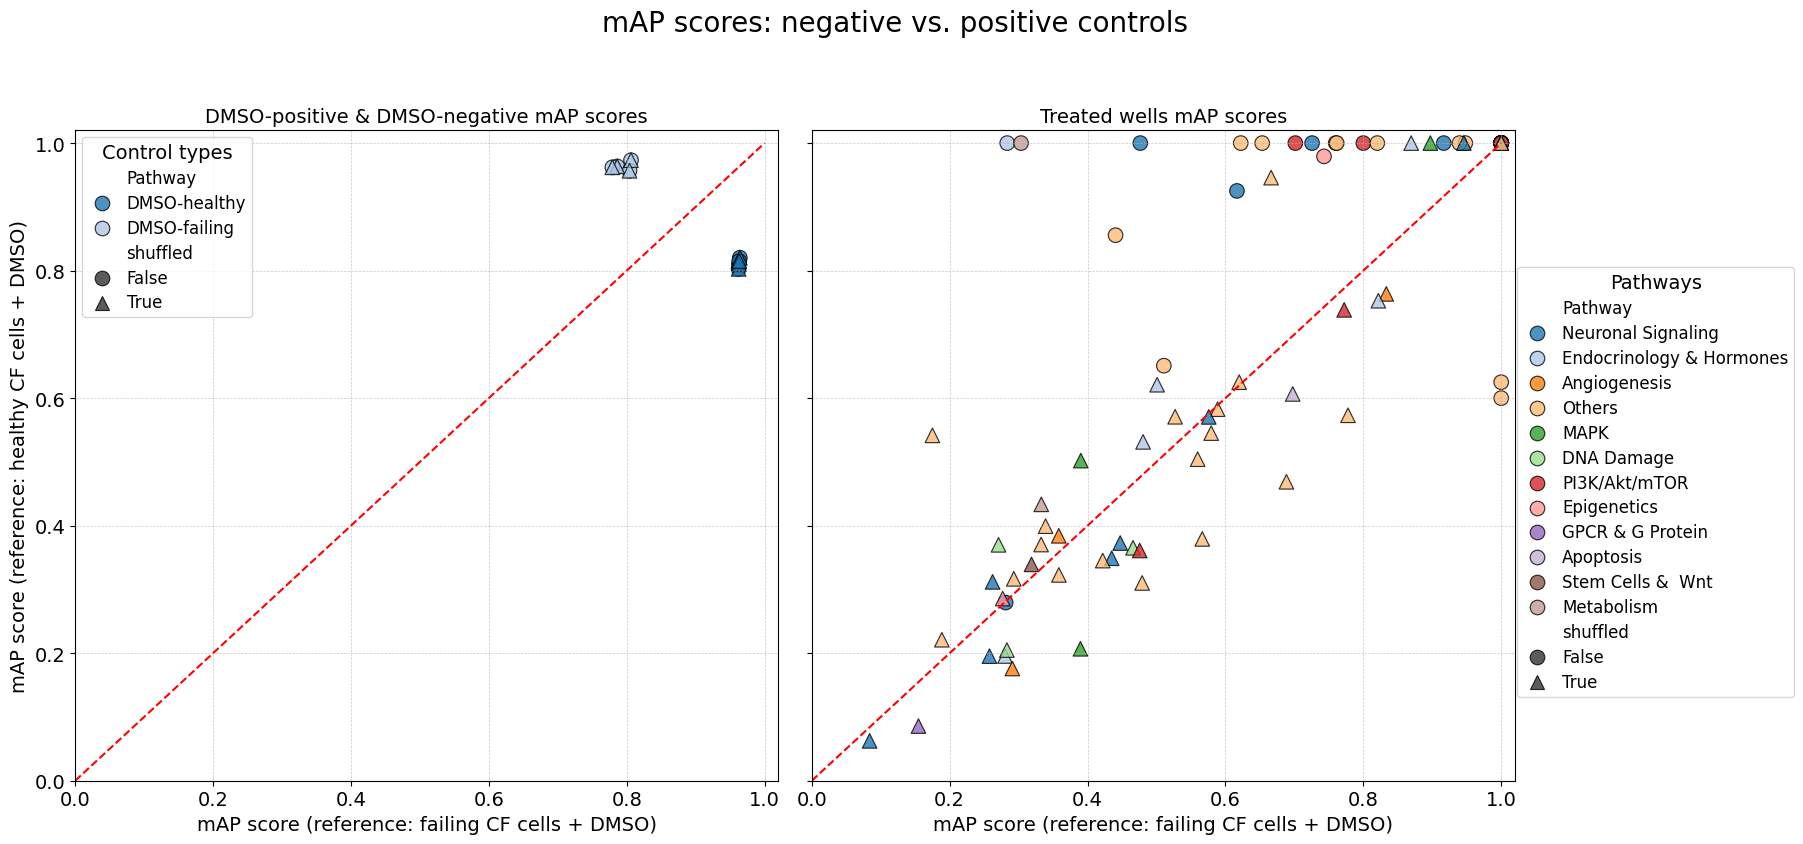

In [9]:
# Separate the data into two subsets: DMSO-positive and DMSO-negative vs. the rest
dmso_positive_negative = all_map_df[
    all_map_df["Pathway"].str.contains("DMSO", na=False)
]
other_pathways = all_map_df[~all_map_df["Pathway"].str.contains("DMSO", na=False)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# Plot DMSO-positive & DMSO-negative
sns.scatterplot(
    data=dmso_positive_negative,
    x="negative_mean_average_precision",
    y="positive_mean_average_precision",
    hue="Pathway",
    style="shuffled",
    markers={True: "^", False: "o"},
    palette="tab20",
    ax=axes[0],
    s=110,
    edgecolor="black",
    alpha=0.8,
)
axes[0].plot(
    [0, 1], [0, 1], color="red", linestyle="--", linewidth=1.5
)  # Diagonal line
axes[0].set_xlim(0, 1.02)
axes[0].set_ylim(0, 1.02)
axes[0].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
axes[0].set_xlabel("mAP score (reference: failing CF cells + DMSO)", fontsize=14)
axes[0].set_ylabel("mAP score (reference: healthy CF cells + DMSO)", fontsize=14)
axes[0].set_title("DMSO-positive & DMSO-negative mAP scores", fontsize=14)
axes[0].tick_params(axis="both", which="major", labelsize=14)

# Updating legend values from DMSO-positive and DMSO-negative to DMSO-healthy and DMSO-failing
dmso_legend = axes[0].legend_
if dmso_legend is not None:
    dmso_legend.set_title("Control types", prop={"size": 14})  
    for text in dmso_legend.get_texts():
        if text.get_text() == "DMSO-positive":
            text.set_text("DMSO-healthy")
        elif text.get_text() == "DMSO-negative":
            text.set_text("DMSO-failing")
        text.set_fontsize(12)  

# Plotting the mAP scores of treated wells
sns.scatterplot(
    data=other_pathways,
    x="negative_mean_average_precision",
    y="positive_mean_average_precision",
    style="shuffled",
    markers={True: "^", False: "o"},
    hue="Pathway",
    palette="tab20",
    ax=axes[1],
    s=110,
    edgecolor="black",
    alpha=0.8,
)


# Updating axes values
axes[1].plot(
    [0, 1], [0, 1], color="red", linestyle="--", linewidth=1.5
)  # Diagonal line
axes[1].set_xlim(0, 1.02)
axes[1].set_ylim(0, 1.02)
axes[1].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
axes[1].set_xlabel("mAP score (reference: failing CF cells + DMSO)", fontsize=14)
axes[1].set_ylabel("mAP score (reference: healthy CF cells + DMSO)", fontsize=14)
axes[1].set_title("Treated wells mAP scores", fontsize=14)
axes[1].tick_params(axis="both", which="major", labelsize=14)


# Remove the default legend and add a new one
axes[1].legend_.remove()
axes[1].legend(
    loc="upper center",
    bbox_to_anchor=(1.15, 1),
    fancybox=True,
    ncol=1,
)

# Adjust the legend position
axes[1].legend_.set_bbox_to_anchor((1.20, .8))
trt_map_legend = axes[1].legend_
if trt_map_legend is not None:
    trt_map_legend.set_title("Pathways", prop={"size": 14})  
    for text in trt_map_legend.get_texts():
        text.set_fontsize(12)  


# Adjust the legend title size for only axes[1]:
trt_map_legend.set_title("Pathways", prop={"size": 14})  # Increase legend title size

# Adjust layout and add a main title
fig.suptitle("mAP scores: negative vs. positive controls", fontsize=20, y=1.05)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig(fig_dir_path / "map_scores_separated.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

The scatter plot provides insights into how treatments affect failing CF cells compared to both control conditions. Here’s how to interpret different regions of the plot:

- **High mAP score on the Y-axis, low mAP score on the X-axis**:
This indicates that the compound’s effect causes failing CF cells to resemble the negative control (Failing CF cells) and does not resemble to the positive control (Healthy CF cells + DMSO).

- **High mAP scores on both the Y-axis and X-axis**:
This suggests that the compound triggers a distinct cellular state not well-represented by either control. The high mAP scores on both axes indicate that the compound significantly alters the cells in ways that do not align closely with the negative or positive control conditions.

- **Low mAP score on the Y-axis, high mAP score on the X-axis**:
This demonstrates a potential reversal effect. The compound causes failing CF cells to move away from the negative control (Failing CF cells + DMSO) and closer to resembling the positive control (Healthy CF cells).

- **Low mAP scores on both the X-axis and Y-axis**:
This could indicate potential quality control issues, such as poor-quality replicates or inconsistencies in how the compound was applied. 

## Differential mAP scores Histogram analysis (Pathway Level)

The primary goal of using differential mAP scores (delta_MAP) in this high-content screening is to evaluate the therapeutic potential of 550 compounds for reversing cardiac fibrosis. By comparing the morphological profiles of treated diseased cells against two controls failing cardiac cells + DMSO (negative control) and healthy cardiac cells + DMSO (positive control) the differential mAP scores help identify compounds that effectively shift the diseased phenotype toward the healthy state.

$$
\begin{equation}
\Delta \text{mAP} = \text{mAP}_{\text{Negative Control}} - \text{mAP}_{\text{Positive Control}}
\end{equation}
$$

$\text{mAP}_{\text{Negative Control}}  ( X )$:

- The mean average precision score when comparing treated diseased cells to the failing control.
- A **lower** $X$ indicates that the compound’s effect is similar to the diseased phenotype (minimal therapeutic relevance).
- A **higher**$X$ indicates that the compound’s effect is different to the diseased phenotype (potential therapeutic relevance)

$\text{mAP}_{\text{Positive Control}}  ( Y )$:

- The mean average precision score when comparing treated diseased cells to the healthy control.
- A **lower** $Y$ indicates that the compound shifts the disease state closer to to the healthy type (potential therapeutic relevance)
- A **higher** $Y$ indicates that the compound shifts the diseased cells further to the healthy phenotype. (minimal therapeutic relevance)

$ \Delta \text{mAP}  ( X - Y ):$
- The difference between  $\text{mAP}{\text{Positive Control}}  and  \text{mAP}{\text{Negative Control}}$ .
- This score provides a measure of how effectively a compound reverses the failing phenotype in a single value.

#### What is the range of the scores?

The range of these scores is [-1, 1]

- **Positive** $\Delta \text{mAP}$ $(0 < \Delta \text{mAP} \leq 1)$:  
  Indicates the compound aligns more with the healthy phenotype than the diseased phenotype.

- **Negative** $\Delta \text{mAP}$ $(-1 \leq \Delta \text{mAP} < 0)$:  
  Indicates the compound aligns more with the diseased phenotype than the healthy phenotype.

- **Zero** $\Delta \text{mAP}$ $(\Delta \text{mAP} = 0)$:  
  Indicates no difference between the compound's effect on healthy and diseased phenotypes.


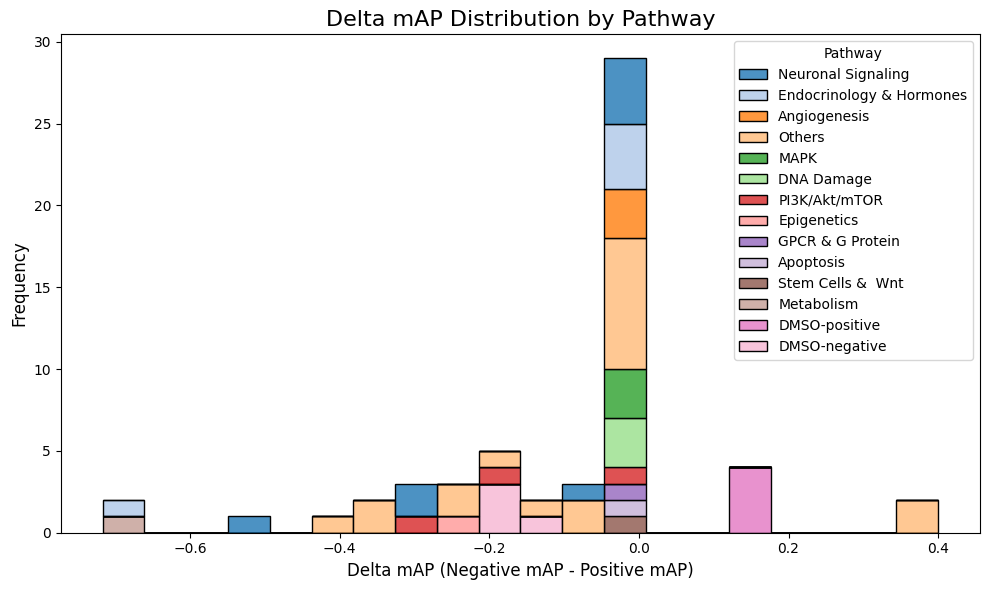

In [10]:
# Plot stacked bar histogram using seaborn
plt.figure(figsize=(10, 6))

# plot delta mAP histogram for original data
sns.histplot(
    data=all_map_df.loc[~all_map_df["shuffled"]],
    x="delta_mAP",
    hue="Pathway",
    multiple="stack",
    bins=20,
    palette="tab20",
    alpha=0.8,
)

# Add plot labels and title
plt.title("Delta mAP Distribution by Pathway", fontsize=16)
plt.xlabel("Delta mAP (Negative mAP - Positive mAP)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()


# save plot
plt.savefig(fig_dir_path / "delta_mAP_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

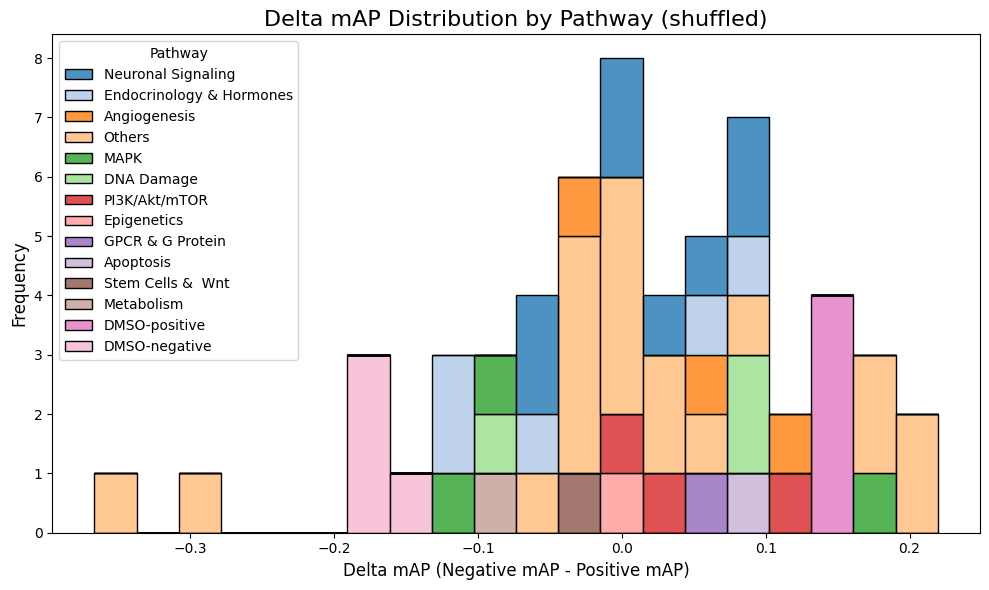

In [11]:
# Plot stacked bar histogram using seaborn
plt.figure(figsize=(10, 6))

# plot delta mAP histogram for shuffled data
sns.histplot(
    data=all_map_df.loc[all_map_df["shuffled"]],
    x="delta_mAP",
    hue="Pathway",
    multiple="stack",
    bins=20,
    palette="tab20",
    alpha=0.8,
)

# Add plot labels and title
plt.title("Delta mAP Distribution by Pathway (shuffled)", fontsize=16)
plt.xlabel("Delta mAP (Negative mAP - Positive mAP)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()


# save plot
plt.savefig(fig_dir_path / "shuffled_delta_mAP_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Leveraging Delta mAP can also provide an opportunity to rank them from highest to lowest and identify potential hits. 

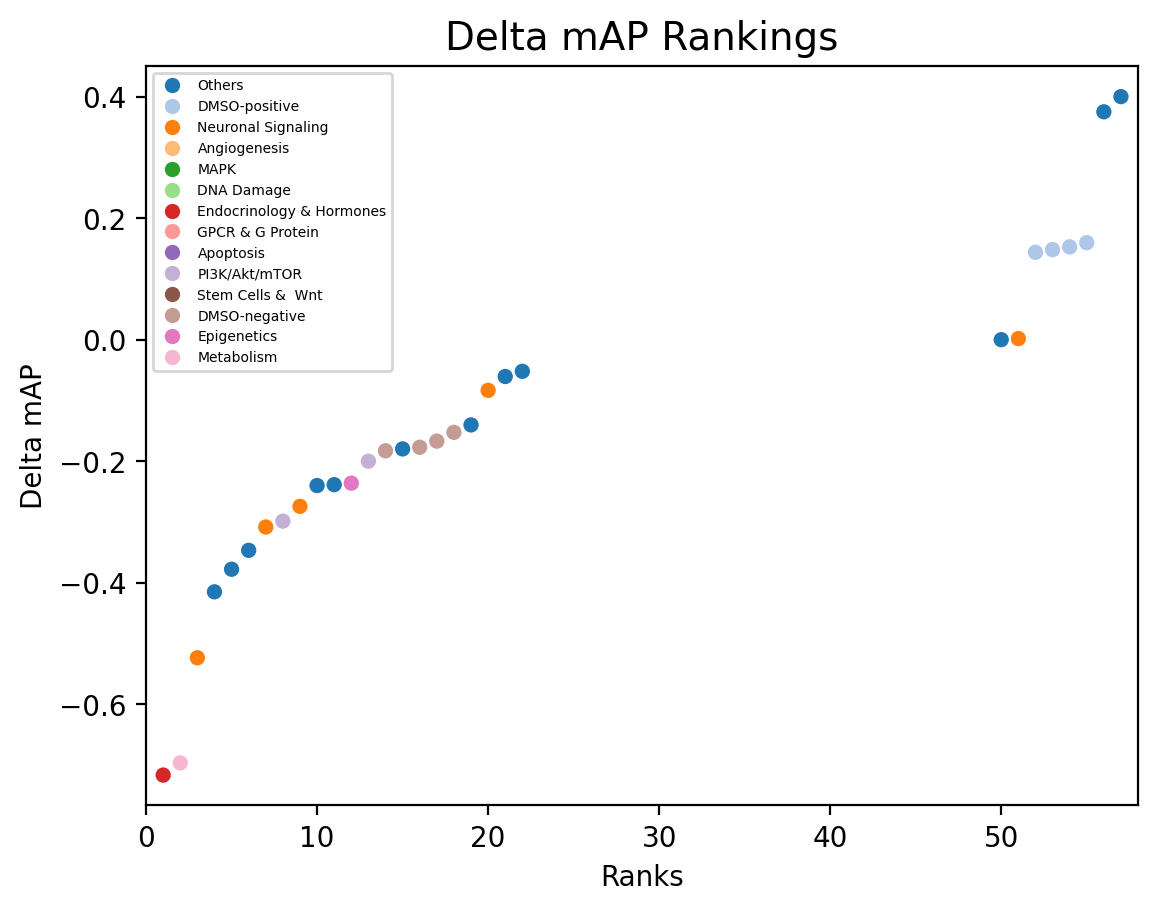

In [12]:
# whole figure configs
plt.figure(dpi=200)

# only getting the delta map scores
delta_map_df = all_map_df.loc[~all_map_df["shuffled"]][["Metadata_treatment", "delta_mAP", "Pathway"]]

# Add ranks to the DataFrame
delta_map_df["rank"] = delta_map_df["delta_mAP"].rank(ascending=True, method="max")
delta_map_df = delta_map_df.sort_values(by="rank", ascending=False)

# creating scatter plot of all Delta mAP score ranks
sns.scatterplot(
    data=delta_map_df, x="rank", y="delta_mAP", hue="Pathway", palette="tab20"
)

# setting figure title names
plt.title("Delta mAP Rankings", fontsize=14)
plt.xlabel("Ranks")
plt.ylabel("Delta mAP")

# setting the axis values
axis_padding = 0.05
plt.xlim(0, delta_map_df["rank"].max() + 1)
plt.ylim(
    -axis_padding + delta_map_df["delta_mAP"].min(),
    delta_map_df["delta_mAP"].max() + axis_padding,
)

# updating the legend
plt.rc("legend", fontsize=5)
plt.rc("legend", title_fontsize=10)
plt.legend(loc="upper left")

# save ranked delta maps
delta_map_df.to_csv(map_analysis_results_dir / "ranked_delta_mAPs.csv", index=False)

# save plot
plt.savefig(fig_dir_path / "delta_mAP_rankings.png", dpi=300, bbox_inches="tight")

# display plot
plt.show()

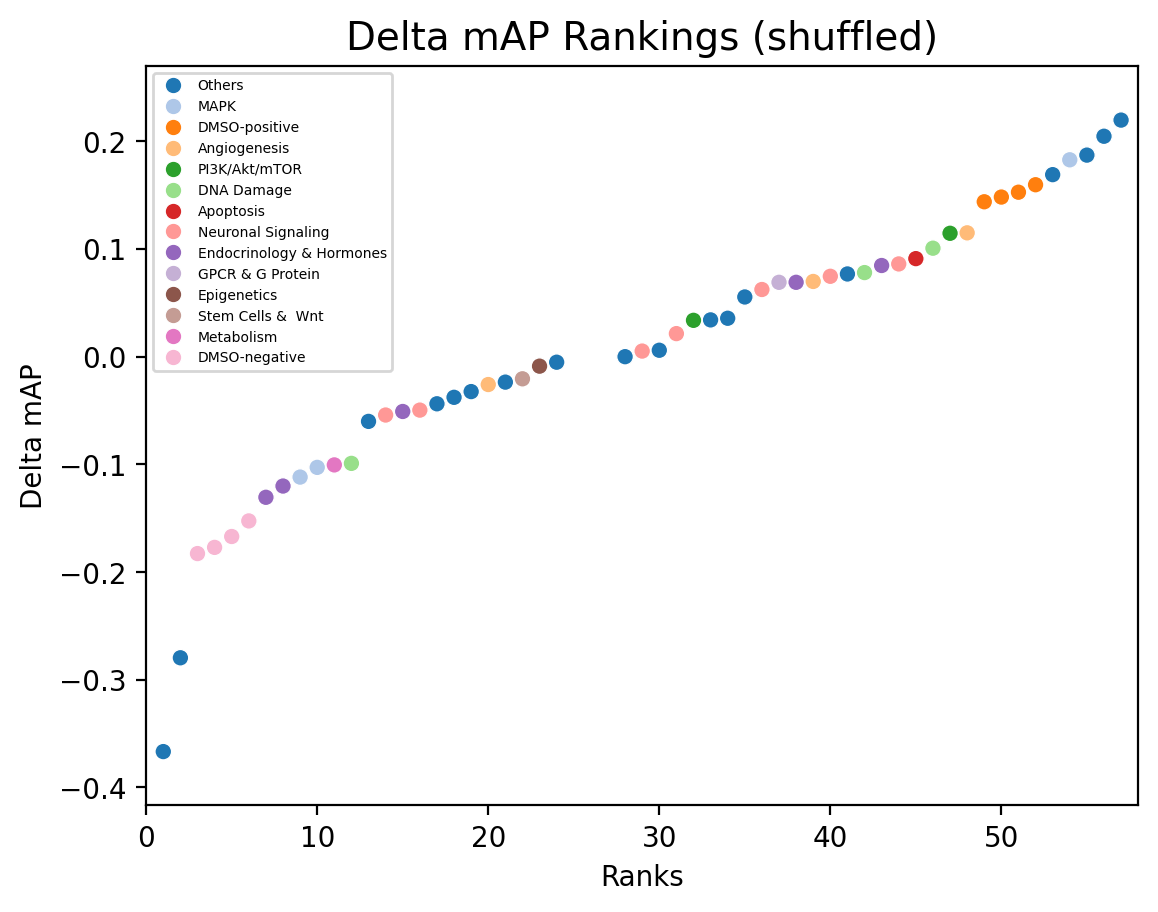

In [13]:
# whole figure configs
plt.figure(dpi=200)

# only getting the delta map scores that were generated from the shuffled feature space data
delta_map_df = all_map_df.loc[all_map_df["shuffled"]][["Metadata_treatment", "delta_mAP", "Pathway"]]

# Add ranks to the DataFrame
delta_map_df["rank"] = delta_map_df["delta_mAP"].rank(ascending=True, method="max")
delta_map_df = delta_map_df.sort_values(by="rank", ascending=False)

# creating scatter plot of all Delta mAP score ranks
sns.scatterplot(
    data=delta_map_df, x="rank", y="delta_mAP", hue="Pathway", palette="tab20"
)

# setting figure title names
plt.title("Delta mAP Rankings (shuffled)", fontsize=14)
plt.xlabel("Ranks")
plt.ylabel("Delta mAP")

# setting the axis values
axis_padding = 0.05
plt.xlim(0, delta_map_df["rank"].max() + 1)
plt.ylim(
    -axis_padding + delta_map_df["delta_mAP"].min(),
    delta_map_df["delta_mAP"].max() + axis_padding,
)

# updating the legend
plt.rc("legend", fontsize=5)
plt.rc("legend", title_fontsize=10)
plt.legend(loc="upper left")

# save ranked delta maps
delta_map_df.to_csv(map_analysis_results_dir / "shuffled_ranked_delta_mAPs.csv", index=False)

# save plot
plt.savefig(fig_dir_path / "shuffled_delta_mAP_rankings.png", dpi=300, bbox_inches="tight")

# display plot
plt.show()